#### Importing Libraries 

In [ ]:
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, TrivialAugmentWide, Normalize, AugMix, AutoAugment, RandAugment
from torch.nn import CrossEntropyLoss, Softmax
import torchvision.models as models
import glob
import os
import PIL 
import ipyplot
import tqdm
import cv2
import numpy as np
import random
import opendatasets as od
from dataclasses import dataclass
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
from sklearn.utils.class_weight import compute_class_weight
from copy import copy 
from torchmetrics import F1Score
import torchinfo


##### Selecting the Device type based on availability 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


##### Downloading Datasets from Kaggle

In [ ]:
od.download("https://www.kaggle.com/competitions/plant-seedlings-classification/data")

Skipping, found downloaded files in ".\plant-seedlings-classification" (use force=True to force download)


##### Visualizing DataSets Based on Category

In [ ]:
image_url = './plant-seedlings-classification/train/*/*.*'
image_list = []
category = []
import matplotlib.pyplot as plt
all_files =  glob.glob(image_url)
for i in all_files:
    image_list.append(i)
    category.append(i.split('\\')[-2])
    


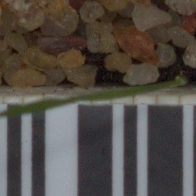
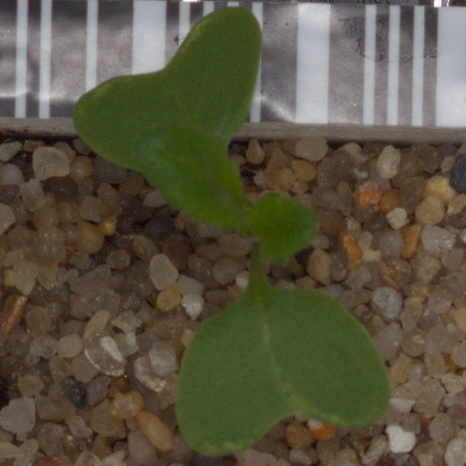
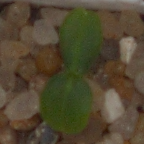
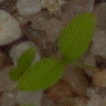
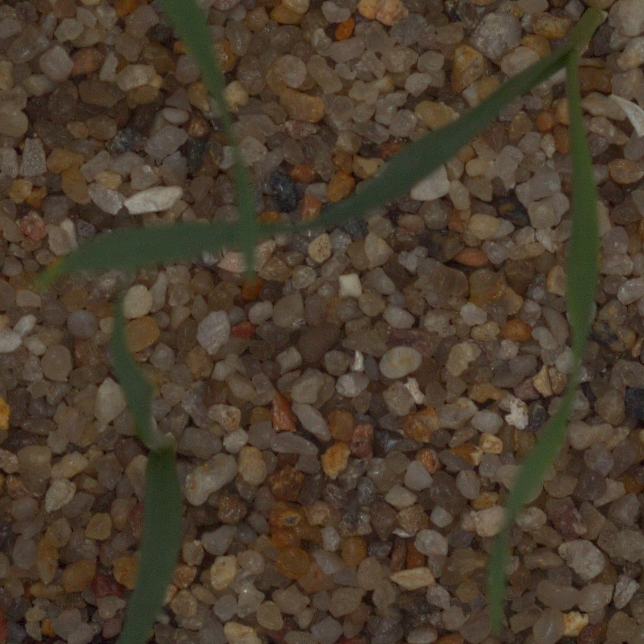
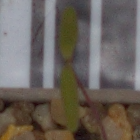
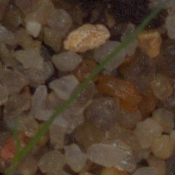
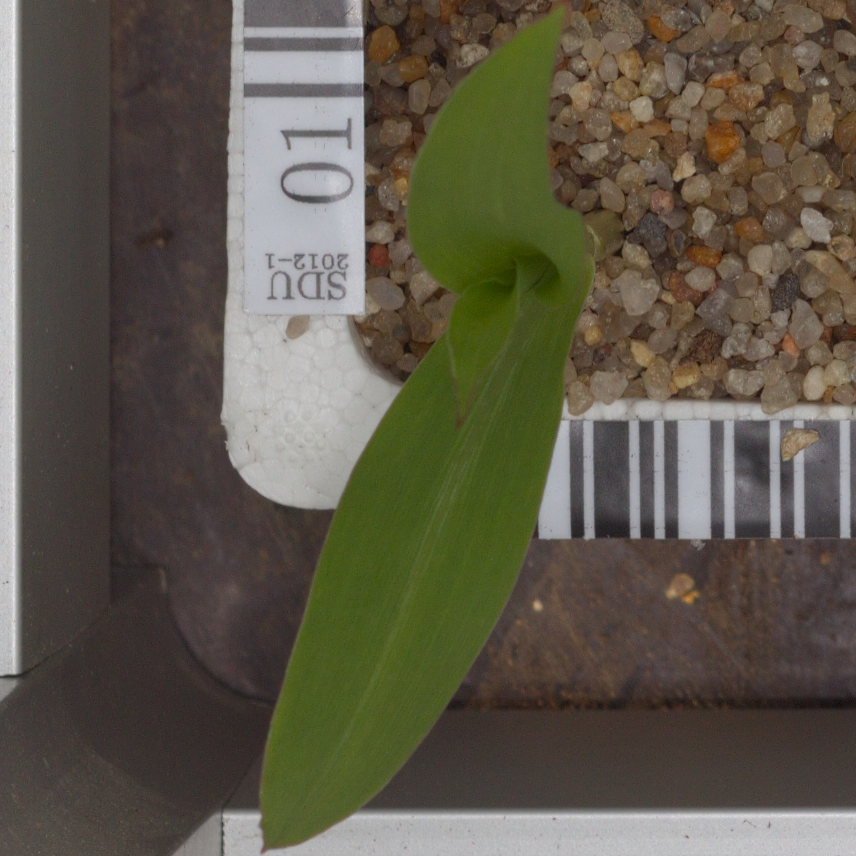
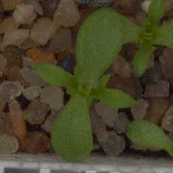
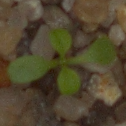
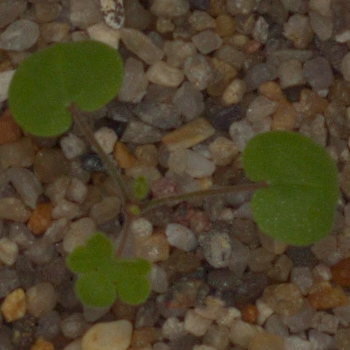
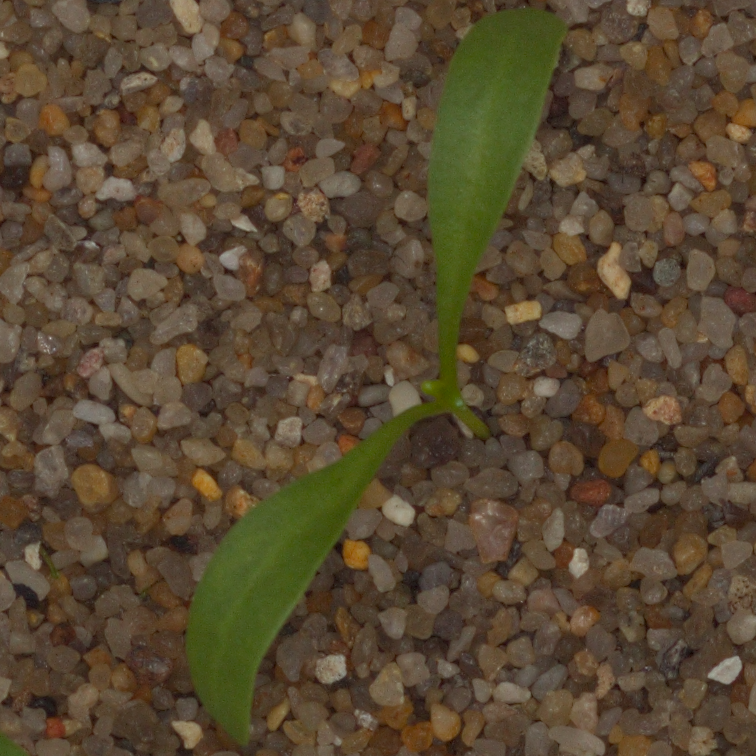


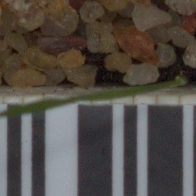
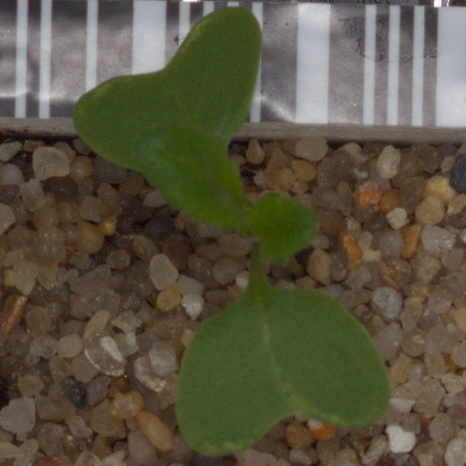
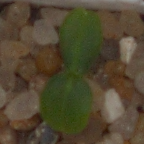
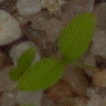
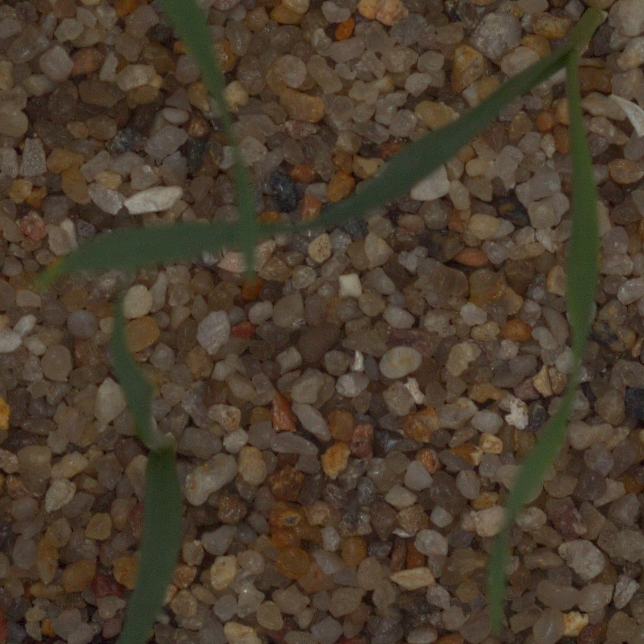
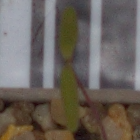
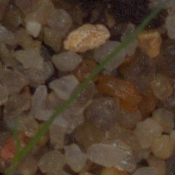
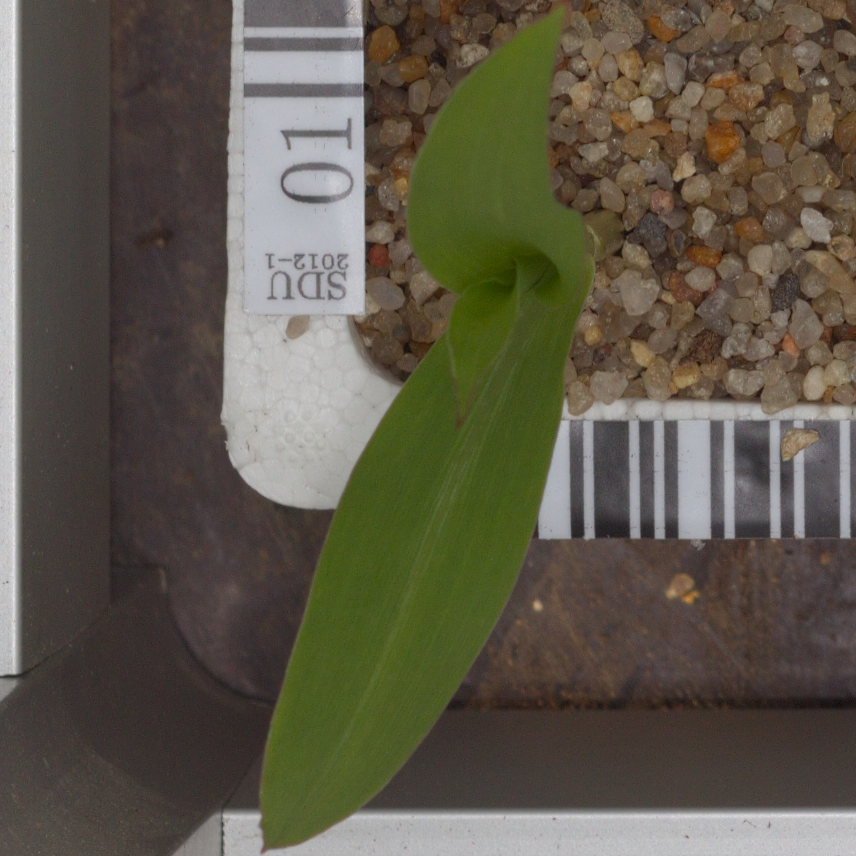
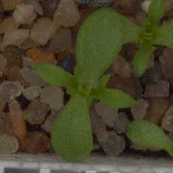
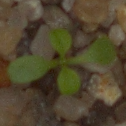
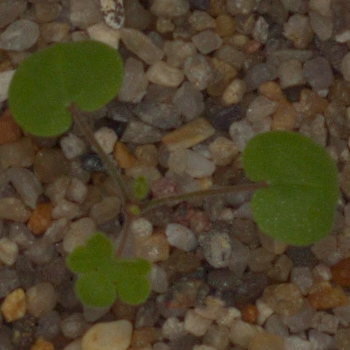
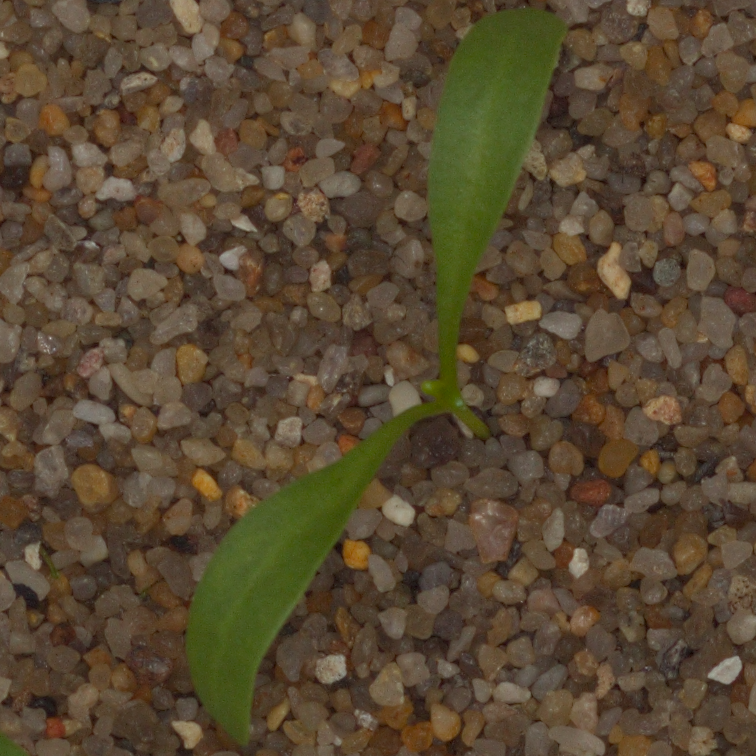

In [ ]:
ipyplot.plot_class_representations( image_list, category,img_width=150, force_b64=True,show_url=False, )


##### Preprocessing Images 

In [ ]:


@dataclass
class PreprocessConfiguration:
    """
    A configuration object for preprocessing image data.
    Attributes:
    batch_size (int): The batch size for the data loaders.
    resize (int): The size to which the images should be resized.
    train_size (float): The proportion of the dataset to use for training.
    image_url_for_std (str): The URL of the images to use for calculating mean and standard deviation.
    image_url_for_train (str): The URL of the images to use for training.
    num_workers (int): The number of workers to use for loading the data.
    prediction_data (bool): A flag indicating whether the data is for prediction or not.
    """
    batch_size: int = 32
    resize:int = 224
    train_size: float = 0.8
    image_url_for_std: str = './plant-seedlings-classification/train/*/*.*'
    image_url_for_train: str = './plant-seedlings-classification/train/'
    num_workers:int = os.cpu_count()
    prediction_data:bool = False



In [ ]:

def mean_std_images(image_url:str, sample:int) -> tuple:
    """Calculates the mean and standard deviation of a sample of images.
    
    Args:
        image_url (str): A glob-style file pattern that specifies the location of the
            images to be processed.
        sample (int): The number of images to be randomly sampled from the image_url.
    
    Returns:
        tuple: A tuple containing the mean and standard deviation of the image sample,
            with the mean and standard deviation of each color channel computed 
            separately. The mean and standard deviation are returned as numpy arrays
            with dtype np.float32 and shape (3,).
    """
    means = np.array([0, 0, 0], dtype=np.float32)
    stds = np.array([0, 0, 0], dtype=np.float32)
    total_images = 0
    randomly_sample = sample
    for f in tqdm.tqdm(random.sample(glob.glob(image_url, recursive = True), randomly_sample)):
        img = cv2.imread(f)
        means += img.mean(axis=(0,1))
        stds += img.std(axis=(0,1))
        total_images += 1
    means = means / (total_images * 255.)
    stds = stds / (total_images * 255.)
    return means, stds


def preprocess_image_folder_data( preprocessing_configuration = PreprocessConfiguration()):
    """Preprocesses image data for training and testing.
    
    Downloads the data for the specified Kaggle competition if it is not already 
    present on the local machine. Calculates the mean and standard deviation of 
    a random sample of images, and applies these statistics as normalization 
    parameters for the training and test datasets. If the preprocessing_configuration
    parameter specifies that the data is for prediction, no train/test split is performed
    and the full dataset is returned as a PyTorch DataLoader object.
    
    Args:
        preprocessing_configuration (PreprocessConfiguration, optional): An 
            instance of the PreprocessConfiguration class containing information 
            about the image data and the desired preprocessing behavior. Defaults 
            to an instance of the PreprocessConfiguration class with default values.
    
    Returns:
        tuple: A tuple containing PyTorch DataLoader objects for the training 
            and test datasets, respectively. If the preprocessing_configuration 
            parameter specifies that the data is for prediction, returns a 
            single DataLoader object for the full dataset.
    """
    print('Step 1: Preprocessing Image')
    all_files =  glob.glob(preprocessing_configuration.image_url_for_train)

    print('Step 1.1: Randomly calculating mean and standard for Train Transform normalize')

    mean, std = mean_std_images(preprocessing_configuration.image_url_for_std, 3000) 
   

    print('Step 1.2: Loading Image from folders')
    
    full_train_dataset = ImageFolder(
        root=preprocessing_configuration.image_url_for_train,
        transform= None
            )
    if not preprocessing_configuration.prediction_data:
        train_size = int(preprocessing_configuration.train_size * len(full_train_dataset))
        test_size = len(full_train_dataset) - train_size
    
        print('Step 1.3: Train/Test Split Datasets')
    
        train_data, test_data = torch.utils.data.random_split(full_train_dataset, [train_size, test_size])
        train_data.dataset = copy(full_train_dataset)
        train_data.dataset.transform = Compose([Resize((preprocessing_configuration.resize,preprocessing_configuration.resize)), 
                        RandAugment(),
                        ToTensor(),
                        Normalize(mean=mean,std=std)])
        test_data.dataset.transform = Compose([Resize((preprocessing_configuration.resize,preprocessing_configuration.resize)), 
                        ToTensor(),
                        Normalize(mean=mean,std=std)])

    if preprocessing_configuration.prediction_data:
        valid_loader = DataLoader(
        full_train_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=preprocessing_configuration.num_workers, pin_memory=True, 
        )
        return valid_loader


    BATCH_SIZE = preprocessing_configuration.batch_size

    train_loader = DataLoader(
        train_data, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=preprocessing_configuration.num_workers, pin_memory=True
    )
    
    valid_loader = DataLoader(
        test_data, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=preprocessing_configuration.num_workers, pin_memory=True, 
    )


    return mean, std, train_loader, valid_loader

In [ ]:
full_train_dataset = ImageFolder(
        root=PreprocessConfiguration().image_url_for_train
            )

In [ ]:
mean, std, train_loader, valid_loader = preprocess_image_folder_data()

Step 1: Preprocessing Image
Step 1.1: Randomly calculating mean and standard for Train Transform normalize


100%|██████████| 3000/3000 [00:56<00:00, 53.32it/s] 

Step 1.2: Loading Image from folders
Step 1.3: Train/Test Split Datasets


In [ ]:
weights = models.EfficientNet_B0_Weights.DEFAULT
weights
efficienet  = models.efficientnet_b0(weights=weights).to(device)
efficienet

torchinfo.summary( efficienet, col_width=20, row_settings=['var_names'], input_size=(32, 3,224,224))

Layer (type (var_name))                                      Output Shape         Param #
EfficientNet (EfficientNet)                                  [32, 1000]           --
├─Sequential (features)                                      [32, 1280, 7, 7]     --
│    └─Conv2dNormActivation (0)                              [32, 32, 112, 112]   --
│    │    └─Conv2d (0)                                       [32, 32, 112, 112]   864
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   64
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   --
│    └─Sequential (1)                                        [32, 16, 112, 112]   --
│    │    └─MBConv (0)                                       [32, 16, 112, 112]   1,448
│    └─Sequential (2)                                        [32, 24, 56, 56]     --
│    │    └─MBConv (0)                                       [32, 24, 56, 56]     6,004
│    │    └─MBConv (1)                               

In [ ]:
class EfficientNet(nn.Module):
    """A PyTorch implementation of a ResNet model.
    
    This implementation uses a pre-trained ResNet-101 model and replaces the
    final fully-connected layer with a new linear layer with 12 output units.
    
    Args:
        nn (nn.Module): A PyTorch neural network module.
    
    Attributes:
        resnet (nn.Sequential): A PyTorch Sequential container for the 
            pre-trained ResNet-101 model, with the final two layers removed.
        Linear (nn.Linear): A PyTorch linear layer with 100352 input units
            and 12 output units.
    """
    def __init__(self):
        """Initializes the ResNet model.
        
        Initializes the resnet attribute as a PyTorch Sequential container 
        for the pre-trained ResNet-101 model, with the final two layers removed.
        Initializes the Linear attribute as a PyTorch linear layer with 
        100352 input units and 12 output units.
        """
        super().__init__()
        self.resnet = efficienet.features
        self.adaptiveavg = efficienet.avgpool
        self.dropout = nn.Dropout(0.8)
        self.Linear = nn.Linear(in_features=62720, out_features=12)
    
    def forward(self, X):
        """Forward pass of the ResNet model.
        
        Args:
            X (torch.Tensor): A batch of input data with shape 
                (batch_size, num_channels, height, width).
        
        Returns:
            torch.Tensor: A batch of model output with shape 
                (batch_size, num_outputs).
        """
        X =  self.resnet(X)
        X = self.dropout(X.view(X.shape[0], -1 ))
        X = self.Linear(X)
        return X

In [ ]:

class squeezenet(nn.Module):
    """A PyTorch implementation of a ResNet model.
    
    This implementation uses a pre-trained ResNet-101 model and replaces the
    final fully-connected layer with a new linear layer with 12 output units.
    
    Args:
        nn (nn.Module): A PyTorch neural network module.
    
    Attributes:
        resnet (nn.Sequential): A PyTorch Sequential container for the 
            pre-trained ResNet-101 model, with the final two layers removed.
        Linear (nn.Linear): A PyTorch linear layer with 100352 input units
            and 12 output units.
    """
    def __init__(self):
        """Initializes the ResNet model.
        
        Initializes the resnet attribute as a PyTorch Sequential container 
        for the pre-trained ResNet-101 model, with the final two layers removed.
        Initializes the Linear attribute as a PyTorch linear layer with 
        100352 input units and 12 output units.
        """
        super().__init__()
        self.squeezenet = nn.Sequential(*(list(models.squeezenet1_0().children()))[:-1])
        self.Linear = nn.Linear(in_features=86528, out_features=12)
    
    def forward(self, X):
        """Forward pass of the ResNet model.
        
        Args:
            X (torch.Tensor): A batch of input data with shape 
                (batch_size, num_channels, height, width).
        
        Returns:
            torch.Tensor: A batch of model output with shape 
                (batch_size, num_outputs).
        """
        X =  self.squeezenet(X)
        X = X.view(X.shape[0], -1 )
        X = self.Linear(X)
        return X
    

In [ ]:
models.shufflenet_v2_x0_5()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
class shufflenet(nn.Module):
    """A PyTorch implementation of a ResNet model.
    
    This implementation uses a pre-trained ResNet-101 model and replaces the
    final fully-connected layer with a new linear layer with 12 output units.
    
    Args:
        nn (nn.Module): A PyTorch neural network module.
    
    Attributes:
        resnet (nn.Sequential): A PyTorch Sequential container for the 
            pre-trained ResNet-101 model, with the final two layers removed.
        Linear (nn.Linear): A PyTorch linear layer with 100352 input units
            and 12 output units.
    """
    def __init__(self):
        """Initializes the ResNet model.
        
        Initializes the resnet attribute as a PyTorch Sequential container 
        for the pre-trained ResNet-101 model, with the final two layers removed.
        Initializes the Linear attribute as a PyTorch linear layer with 
        100352 input units and 12 output units.
        """
        super().__init__()
        self.shufflenet =  nn.Sequential(*(list(models.shufflenet_v2_x0_5().children())[:-1]))
        self.Linear = nn.Linear(in_features=50176, out_features=12, bias=True)


    
    def forward(self, X):
        """Forward pass of the ResNet model.
        
        Args:
            X (torch.Tensor): A batch of input data with shape 
                (batch_size, num_channels, height, width).
        
        Returns:
            torch.Tensor: A batch of model output with shape 
                (batch_size, num_outputs).
        """
        X =  self.shufflenet(X)
        X = X.view(X.shape[0], -1 )
        X = self.Linear(X)
        return X

##### Model Building & Configuring 

In [ ]:

class ResNet(nn.Module):
    """A PyTorch implementation of a ResNet model.
    
    This implementation uses a pre-trained ResNet-101 model and replaces the
    final fully-connected layer with a new linear layer with 12 output units.
    
    Args:
        nn (nn.Module): A PyTorch neural network module.
    
    Attributes:
        resnet (nn.Sequential): A PyTorch Sequential container for the 
            pre-trained ResNet-101 model, with the final two layers removed.
        Linear (nn.Linear): A PyTorch linear layer with 100352 input units
            and 12 output units.
    """
    def __init__(self):
        """Initializes the ResNet model.
        
        Initializes the resnet attribute as a PyTorch Sequential container 
        for the pre-trained ResNet-101 model, with the final two layers removed.
        Initializes the Linear attribute as a PyTorch linear layer with 
        100352 input units and 12 output units.
        """
        super().__init__()
        self.resnet = nn.Sequential(*(list(models.resnet101(pretrained=True).children())[:-2]))
        self.Linear = nn.Linear(in_features=100352, out_features=12)
    
    def forward(self, X):
        """Forward pass of the ResNet model.
        
        Args:
            X (torch.Tensor): A batch of input data with shape 
                (batch_size, num_channels, height, width).
        
        Returns:
            torch.Tensor: A batch of model output with shape 
                (batch_size, num_outputs).
        """
        X =  self.resnet(X)
        X = X.view(X.shape[0], -1 )
        X = self.Linear(X)
        return X
    

In [ ]:
class TrainingConfiguration:
    """
    A configuration object for training a PyTorch model.
    Attributes:
    model_name (str): The name of the model.
    epochs (int): The number of epochs to train the model.
    learning_rate (float): The learning rate for the optimizer.
    loss_criteron (nn.Module): The loss criterion to use for training.
    model (nn.Module): The PyTorch model to train.
    optimizer (type[torch.optim.Optimizer]): The optimizer to use for training.
    """
    model_name: str = 'resnet_100_epochs'
    epochs: int=100
    learning_rate: float = 0.001
    loss_criteron :nn = nn.CrossEntropyLoss()
    model: nn.Module = ResNet().to(device)
    optimizer: torch.optim = torch.optim.Adam
    

class TrainingConfigurationV2(TrainingConfiguration):
    """
    A configuration object for training a PyTorch model.
    Attributes:
    model_name (str): The name of the model.
    epochs (int): The number of epochs to train the model.
    learning_rate (float): The learning rate for the optimizer.
    loss_criteron (nn.Module): The loss criterion to use for training.
    model (nn.Module): The PyTorch model to train.
    optimizer (type[torch.optim.Optimizer]): The optimizer to use for training.
    """
    model_name: str = 'effnet_100_epochs'
    epochs: int=100
    learning_rate: float = 0.001
    loss_criteron :nn = nn.CrossEntropyLoss()
    model: nn.Module = EfficientNet().to(device)
    optimizer: torch.optim = torch.optim.Adam


class TrainingConfigurationV3(TrainingConfiguration):
    """
    A configuration object for training a PyTorch model.
    Attributes:
    model_name (str): The name of the model.
    epochs (int): The number of epochs to train the model.
    learning_rate (float): The learning rate for the optimizer.
    loss_criteron (nn.Module): The loss criterion to use for training.
    model (nn.Module): The PyTorch model to train.
    optimizer (type[torch.optim.Optimizer]): The optimizer to use for training.
    """
    model_name: str = 'squeezenet_100_epochs'
    epochs: int=100
    learning_rate: float = 0.001
    loss_criteron :nn = nn.CrossEntropyLoss()
    model: nn.Module = shufflenet().to(device)
    optimizer: torch.optim = torch.optim.Adam


class TrainingConfigurationV4(TrainingConfiguration):
    """
    A configuration object for training a PyTorch model.
    Attributes:
    model_name (str): The name of the model.
    epochs (int): The number of epochs to train the model.
    learning_rate (float): The learning rate for the optimizer.
    loss_criteron (nn.Module): The loss criterion to use for training.
    model (nn.Module): The PyTorch model to train.
    optimizer (type[torch.optim.Optimizer]): The optimizer to use for training.
    """
    model_name: str = 'shufflenet_100_epochs'
    epochs: int=100
    learning_rate: float = 0.001
    loss_criteron :nn = nn.CrossEntropyLoss()
    model: nn.Module = squeezenet().to(device)
    optimizer: torch.optim = torch.optim.Adam
    

In [ ]:

def calculate_class_weights(train_loader):
    """
    Calculate class weights for a PyTorch dataloader.
    The class weights are calculated using the 'balanced' option from
    sklearn.utils.class_weight.compute_class_weight.
    Parameters:
    train_loader (DataLoader): A PyTorch dataloader containing the training data.
    Returns:
    torch.tensor: A tensor of class weights, with one weight for each class.
    """
    targets = torch.tensor([])
    for batch, (X, y) in enumerate(train_loader):
        targets = torch.cat((targets, y), 0)

    class_weights=compute_class_weight(class_weight='balanced' , classes = np.unique(targets), y = targets.numpy())
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def train_model(model, train_loader, loss_criteron, optimizer):
    """
    Train a PyTorch model on a given dataset.
    Parameters:
    model (torch.nn.Module): The PyTorch model to train.
    train_loader (DataLoader): A PyTorch dataloader containing the training data.
    loss_criterion: The criterion used to compute the loss.
    optimizer (torch.optim): The optimizer used to update the model's weights.
    classes (list): A list of class labels.
    Returns:
    tuple: A tuple containing the training accuracy, average loss, and F1 score.
    """
    model.train()
    loss_sum = 0
    total_correct = 0 
    f1 = F1Score(task="multiclass", num_classes=len(full_train_dataset.classes), average='micro' ).to(device)
    pred =  torch.tensor([]).to(device)
    target =  torch.tensor([]).to(device)

    for batch, (X, y) in enumerate(train_loader):
        y_logits =  model(X.to(device))
        loss = loss_criteron(y_logits, y.to(device))
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), 1)
        pred = torch.cat((pred, y_pred),0)
        target = torch.cat((target, y.to(device)), 0)
        loss_sum += loss.to('cpu').item()
        total_correct += torch.sum(torch.eq(y_pred, y.to(device))).to('cpu').item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    f1_score = f1(pred, target)
    accuracy = total_correct/len(train_loader.dataset)
    avg_loss = loss_sum/len(train_loader.dataset)
    return accuracy, avg_loss, f1_score.item()

def val(model, test_loader, loss_criteron):
    """
    Evaluate a PyTorch model on a given dataset.
    Parameters:
    model (torch.nn.Module): The PyTorch model to evaluate.
    test_loader (DataLoader): A PyTorch dataloader containing the test data.
    loss_criterion: The criterion used to compute the loss.
    classes (list): A list of class labels.
    Returns:
    tuple: A tuple containing the test accuracy, average loss, and F1 score.
    """
    model.eval()
    pred =  torch.tensor([]).to(device)
    target =  torch.tensor([]).to(device)
    loss_sum = 0
    total_correct = 0 
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_loader):
            y_logits =  model(X.to(device))
            loss = loss_criteron(y_logits, y.to(device))
            y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            pred = torch.cat((pred, y_pred),0)
            target = torch.cat((target, y.to(device)), 0)
            loss_sum += loss.to('cpu').item()
            total_correct += torch.sum(torch.eq(y_pred, y.to(device))).to('cpu').item()
    f1 = F1Score(task="multiclass", num_classes=len(full_train_dataset.classes), average='micro' ).to(device)
    f1_score = f1(pred, target)    
    accuracy = total_correct/len(test_loader.dataset)
    avg_loss = loss_sum/len(test_loader.dataset)
    return accuracy, avg_loss, f1_score.item() 

In [ ]:
from datetime import datetime
import os
timestamp = datetime.now().strftime('%Y-%m-%d %X')
timestamp

'2023-01-15 21:51:16'

In [ ]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'
def summary_tracker( training_config = TrainingConfiguration()):
    from datetime import datetime
    import os
    from torch.utils.tensorboard import SummaryWriter
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    log_dir = os.path.join('runs', training_config.model_name, timestamp, str(training_config.epochs))
    return SummaryWriter(log_dir)


def full_training(train_config: TrainingConfiguration = TrainingConfiguration()):
    """
    Train and evaluate a PyTorch model on a given dataset.
    The model is trained for a specified number of epochs, and its performance is
    evaluated on both the training and test datasets. The model with the best
    performance on the test dataset is saved.
    Parameters:
    train_config (TrainingConfiguration, optional): A configuration object
        containing the model, optimizer, learning rate, and number of epochs.
        Default is an instance of TrainingConfiguration.
    Returns:
    tuple: A tuple containing the mean and standard deviation of the training data,
        the best model, and a DataFrame of the model's performance during training.
    """
    writer = summary_tracker(train_config)
    model = train_config.model
    optimizer = train_config.optimizer(params=model.parameters(), lr=train_config.learning_rate)
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    f1_train_lis = []
    f1_test_lis = []
    current_best = 0
    mean, std, train, test = preprocess_image_folder_data()
    
    print('Step 2: Calculating class weights')
    weights = calculate_class_weights(train)
    print('Weights:', weights)
    loss_criteron = nn.CrossEntropyLoss(weight=weights,reduction='mean').to(device)
    print('Step 3: Training Model')
    for epoch in tqdm.tqdm(range(train_config.epochs)):
        accuracy_train, loss_train, f1_train = train_model(model, train , loss_criteron, optimizer)
        accuracy_test, loss_test, f1_test = val(model, test, loss_criteron)
        if current_best < accuracy_test:
            current_best = accuracy_test
            torch.save(model.state_dict(), './' + train_config.model_name +'_best_model.pth')
        train_loss.append(loss_train)
        train_acc.append(accuracy_train)
        f1_train_lis.append(f1_train)
        test_loss.append(loss_test)
        test_acc.append(accuracy_test)
        f1_test_lis.append(f1_test)
        writer.add_scalars(main_tag='Loss', tag_scalar_dict={'Train_Loss': loss_train, 'Test_loss':loss_test}, global_step=epoch)
        writer.add_scalars(main_tag='Accuracy', tag_scalar_dict={'Train Accuracy': accuracy_train, 'Test Accuracy':accuracy_test}, global_step=epoch)
        writer.add_graph(model=model, input_to_model=torch.randn(32, 3,224,224).to(device))
        print('Epoch:', epoch + 1, '/', train_config.epochs, '| train_acc:', round(accuracy_train,2),  '| f1_train:', round(f1_train,2) , 
            '| train_loss:', round(loss_train,2), ' | test_acc:', round(accuracy_test,2), '| f1_test:', round(f1_test,2),'| test_loss:', round(loss_test,2) )
    model_performance_dict = {
        'Train_Accuracy': train_acc,
        'Train_Loss': train_loss,
        'F1_Train': f1_train_lis,
        'Test_Accuracy': test_acc,
        'Test_Loss': test_loss,
        'F1_Test': f1_test_lis
    }
    writer.close()
    performance = pd.DataFrame(model_performance_dict)
    model = torch.load('./' + train_config.model_name +'_best_model.pth')
    return mean, std, model, performance

        

        


NameError: name 'torch' is not defined

In [ ]:
model_details = {}
for train_config in [TrainingConfiguration(), TrainingConfigurationV2(), TrainingConfigurationV3(), TrainingConfigurationV4()]:
    model_mean, model_std, model, model_performance = full_training(train_config)
    model_details[train_config.model_name] = (model_mean, model_std)


Step 1: Preprocessing Image
Step 1.1: Randomly calculating mean and standard for Train Transform normalize


100%|██████████| 3000/3000 [01:07<00:00, 44.50it/s]


Step 1.2: Loading Image from folders
Step 1.3: Train/Test Split Datasets
Step 2: Calculating class weights
Step 3: Training Model


  1%|          | 1/100 [01:48<2:59:43, 108.93s/it]

Epoch: 1 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.17  | test_acc: 0.27 | f1_test: 0.27 | test_loss: 0.11


  2%|▏         | 2/100 [03:40<3:00:08, 110.29s/it]

Epoch: 2 / 100 | train_acc: 0.34 | f1_train: 0.34 | train_loss: 0.06  | test_acc: 0.57 | f1_test: 0.57 | test_loss: 0.04


  3%|▎         | 3/100 [05:38<3:04:33, 114.16s/it]

Epoch: 3 / 100 | train_acc: 0.5 | f1_train: 0.5 | train_loss: 0.05  | test_acc: 0.64 | f1_test: 0.64 | test_loss: 0.04


  4%|▍         | 4/100 [07:29<3:00:11, 112.62s/it]

Epoch: 4 / 100 | train_acc: 0.57 | f1_train: 0.57 | train_loss: 0.04  | test_acc: 0.67 | f1_test: 0.67 | test_loss: 0.03


  5%|▌         | 5/100 [09:17<2:56:05, 111.21s/it]

Epoch: 5 / 100 | train_acc: 0.64 | f1_train: 0.64 | train_loss: 0.03  | test_acc: 0.63 | f1_test: 0.63 | test_loss: 0.04


  6%|▌         | 6/100 [11:06<2:52:43, 110.25s/it]

Epoch: 6 / 100 | train_acc: 0.69 | f1_train: 0.69 | train_loss: 0.03  | test_acc: 0.7 | f1_test: 0.7 | test_loss: 0.03


  7%|▋         | 7/100 [12:55<2:50:08, 109.77s/it]

Epoch: 7 / 100 | train_acc: 0.76 | f1_train: 0.76 | train_loss: 0.02  | test_acc: 0.79 | f1_test: 0.79 | test_loss: 0.02


  8%|▊         | 8/100 [14:43<2:47:42, 109.38s/it]

Epoch: 8 / 100 | train_acc: 0.79 | f1_train: 0.79 | train_loss: 0.02  | test_acc: 0.79 | f1_test: 0.79 | test_loss: 0.02


  9%|▉         | 9/100 [16:30<2:44:43, 108.61s/it]

Epoch: 9 / 100 | train_acc: 0.82 | f1_train: 0.82 | train_loss: 0.02  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 10%|█         | 10/100 [18:13<2:40:13, 106.82s/it]

Epoch: 10 / 100 | train_acc: 0.83 | f1_train: 0.83 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.01


 11%|█         | 11/100 [19:57<2:37:04, 105.89s/it]

Epoch: 11 / 100 | train_acc: 0.84 | f1_train: 0.84 | train_loss: 0.01  | test_acc: 0.82 | f1_test: 0.82 | test_loss: 0.02


 12%|█▏        | 12/100 [21:39<2:33:46, 104.85s/it]

Epoch: 12 / 100 | train_acc: 0.87 | f1_train: 0.87 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 13%|█▎        | 13/100 [23:22<2:31:12, 104.28s/it]

Epoch: 13 / 100 | train_acc: 0.87 | f1_train: 0.87 | train_loss: 0.01  | test_acc: 0.81 | f1_test: 0.81 | test_loss: 0.02


 14%|█▍        | 14/100 [25:06<2:29:18, 104.17s/it]

Epoch: 14 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.81 | f1_test: 0.81 | test_loss: 0.02


 15%|█▌        | 15/100 [26:49<2:27:05, 103.83s/it]

Epoch: 15 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.82 | f1_test: 0.82 | test_loss: 0.02


 16%|█▌        | 16/100 [28:36<2:26:49, 104.88s/it]

Epoch: 16 / 100 | train_acc: 0.9 | f1_train: 0.9 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 17%|█▋        | 17/100 [30:28<2:27:41, 106.77s/it]

Epoch: 17 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.01


 18%|█▊        | 18/100 [32:12<2:25:00, 106.11s/it]

Epoch: 18 / 100 | train_acc: 0.9 | f1_train: 0.9 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.01


 19%|█▉        | 19/100 [33:53<2:21:20, 104.70s/it]

Epoch: 19 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 20%|██        | 20/100 [35:40<2:20:12, 105.16s/it]

Epoch: 20 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.02


 21%|██        | 21/100 [37:25<2:18:24, 105.13s/it]

Epoch: 21 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.83 | f1_test: 0.83 | test_loss: 0.02


 22%|██▏       | 22/100 [39:09<2:16:08, 104.72s/it]

Epoch: 22 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.8 | f1_test: 0.8 | test_loss: 0.03


 23%|██▎       | 23/100 [40:56<2:15:24, 105.51s/it]

Epoch: 23 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.02


 24%|██▍       | 24/100 [42:45<2:15:10, 106.72s/it]

Epoch: 24 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 25%|██▌       | 25/100 [44:35<2:14:30, 107.61s/it]

Epoch: 25 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 26%|██▌       | 26/100 [46:29<2:14:53, 109.37s/it]

Epoch: 26 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.81 | f1_test: 0.81 | test_loss: 0.02


 27%|██▋       | 27/100 [48:27<2:16:20, 112.06s/it]

Epoch: 27 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.69 | f1_test: 0.69 | test_loss: 0.05


 28%|██▊       | 28/100 [50:21<2:15:14, 112.70s/it]

Epoch: 28 / 100 | train_acc: 0.87 | f1_train: 0.87 | train_loss: 0.01  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 29%|██▉       | 29/100 [52:13<2:12:57, 112.37s/it]

Epoch: 29 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 30%|███       | 30/100 [54:13<2:13:56, 114.81s/it]

Epoch: 30 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 31%|███       | 31/100 [56:16<2:14:38, 117.07s/it]

Epoch: 31 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 32%|███▏      | 32/100 [58:05<2:09:57, 114.67s/it]

Epoch: 32 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.02


 33%|███▎      | 33/100 [1:00:03<2:09:20, 115.83s/it]

Epoch: 33 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.02


 34%|███▍      | 34/100 [1:02:04<2:08:57, 117.23s/it]

Epoch: 34 / 100 | train_acc: 0.85 | f1_train: 0.85 | train_loss: 0.02  | test_acc: 0.82 | f1_test: 0.82 | test_loss: 0.02


 35%|███▌      | 35/100 [1:03:58<2:06:08, 116.43s/it]

Epoch: 35 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.02


 36%|███▌      | 36/100 [1:05:46<2:01:20, 113.76s/it]

Epoch: 36 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 37%|███▋      | 37/100 [1:07:34<1:57:42, 112.11s/it]

Epoch: 37 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.82 | f1_test: 0.82 | test_loss: 0.03


 38%|███▊      | 38/100 [1:09:22<1:54:29, 110.80s/it]

Epoch: 38 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 39%|███▉      | 39/100 [1:11:11<1:52:13, 110.38s/it]

Epoch: 39 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 40%|████      | 40/100 [1:12:59<1:49:36, 109.61s/it]

Epoch: 40 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 41%|████      | 41/100 [1:14:46<1:47:04, 108.89s/it]

Epoch: 41 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 42%|████▏     | 42/100 [1:16:35<1:45:17, 108.93s/it]

Epoch: 42 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


 43%|████▎     | 43/100 [1:18:23<1:43:13, 108.66s/it]

Epoch: 43 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 44%|████▍     | 44/100 [1:20:11<1:41:15, 108.48s/it]

Epoch: 44 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 45%|████▌     | 45/100 [1:21:59<1:39:09, 108.17s/it]

Epoch: 45 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.02


 46%|████▌     | 46/100 [1:23:47<1:37:18, 108.13s/it]

Epoch: 46 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.81 | f1_test: 0.81 | test_loss: 0.03


 47%|████▋     | 47/100 [1:25:34<1:35:21, 107.95s/it]

Epoch: 47 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 48%|████▊     | 48/100 [1:27:23<1:33:39, 108.07s/it]

Epoch: 48 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.02


 49%|████▉     | 49/100 [1:29:12<1:32:06, 108.36s/it]

Epoch: 49 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 50%|█████     | 50/100 [1:30:59<1:29:58, 107.97s/it]

Epoch: 50 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 51%|█████     | 51/100 [1:32:46<1:27:52, 107.61s/it]

Epoch: 51 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 52%|█████▏    | 52/100 [1:34:32<1:25:53, 107.37s/it]

Epoch: 52 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 53%|█████▎    | 53/100 [1:36:19<1:24:03, 107.30s/it]

Epoch: 53 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 54%|█████▍    | 54/100 [1:38:07<1:22:15, 107.29s/it]

Epoch: 54 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.02


 55%|█████▌    | 55/100 [1:39:54<1:20:34, 107.43s/it]

Epoch: 55 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 56%|█████▌    | 56/100 [1:41:42<1:18:53, 107.57s/it]

Epoch: 56 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


 57%|█████▋    | 57/100 [1:43:28<1:16:45, 107.11s/it]

Epoch: 57 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.02


 58%|█████▊    | 58/100 [1:45:15<1:14:55, 107.04s/it]

Epoch: 58 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.03


 59%|█████▉    | 59/100 [1:47:04<1:13:28, 107.54s/it]

Epoch: 59 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


 60%|██████    | 60/100 [1:48:51<1:11:34, 107.37s/it]

Epoch: 60 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 61%|██████    | 61/100 [1:50:39<1:09:53, 107.52s/it]

Epoch: 61 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


 62%|██████▏   | 62/100 [1:52:26<1:07:58, 107.32s/it]

Epoch: 62 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 63%|██████▎   | 63/100 [1:54:13<1:06:05, 107.18s/it]

Epoch: 63 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.02


 64%|██████▍   | 64/100 [1:56:00<1:04:17, 107.16s/it]

Epoch: 64 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 65%|██████▌   | 65/100 [1:57:46<1:02:22, 106.93s/it]

Epoch: 65 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


 66%|██████▌   | 66/100 [1:59:34<1:00:49, 107.33s/it]

Epoch: 66 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.02


 67%|██████▋   | 67/100 [2:01:24<59:21, 107.91s/it]  

Epoch: 67 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.02


 68%|██████▊   | 68/100 [2:03:10<57:21, 107.53s/it]

Epoch: 68 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 69%|██████▉   | 69/100 [2:04:59<55:47, 107.99s/it]

Epoch: 69 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.05


 70%|███████   | 70/100 [2:06:47<53:57, 107.91s/it]

Epoch: 70 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 71%|███████   | 71/100 [2:08:34<52:03, 107.70s/it]

Epoch: 71 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


 72%|███████▏  | 72/100 [2:10:21<50:04, 107.32s/it]

Epoch: 72 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.03


 73%|███████▎  | 73/100 [2:12:09<48:24, 107.58s/it]

Epoch: 73 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.02


 74%|███████▍  | 74/100 [2:13:56<46:30, 107.34s/it]

Epoch: 74 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.02


 75%|███████▌  | 75/100 [2:15:44<44:49, 107.57s/it]

Epoch: 75 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.02


 76%|███████▌  | 76/100 [2:17:32<43:03, 107.66s/it]

Epoch: 76 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 77%|███████▋  | 77/100 [2:19:19<41:17, 107.71s/it]

Epoch: 77 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


 78%|███████▊  | 78/100 [2:21:07<39:29, 107.70s/it]

Epoch: 78 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 79%|███████▉  | 79/100 [2:22:56<37:48, 108.03s/it]

Epoch: 79 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 80%|████████  | 80/100 [2:24:43<35:56, 107.83s/it]

Epoch: 80 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 81%|████████  | 81/100 [2:26:30<34:04, 107.61s/it]

Epoch: 81 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 82%|████████▏ | 82/100 [2:28:19<32:22, 107.89s/it]

Epoch: 82 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 83%|████████▎ | 83/100 [2:30:06<30:28, 107.54s/it]

Epoch: 83 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 84%|████████▍ | 84/100 [2:31:53<28:38, 107.40s/it]

Epoch: 84 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.02


 85%|████████▌ | 85/100 [2:33:40<26:52, 107.52s/it]

Epoch: 85 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 86%|████████▌ | 86/100 [2:35:28<25:07, 107.65s/it]

Epoch: 86 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 87%|████████▋ | 87/100 [2:37:17<23:22, 107.88s/it]

Epoch: 87 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 88%|████████▊ | 88/100 [2:39:05<21:35, 107.93s/it]

Epoch: 88 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 89%|████████▉ | 89/100 [2:40:53<19:49, 108.11s/it]

Epoch: 89 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 90%|█████████ | 90/100 [2:42:41<17:59, 107.98s/it]

Epoch: 90 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 91%|█████████ | 91/100 [2:44:30<16:13, 108.13s/it]

Epoch: 91 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 92%|█████████▏| 92/100 [2:46:18<14:25, 108.13s/it]

Epoch: 92 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 93%|█████████▎| 93/100 [2:48:06<12:37, 108.27s/it]

Epoch: 93 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 94%|█████████▍| 94/100 [2:49:54<10:48, 108.14s/it]

Epoch: 94 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 95%|█████████▌| 95/100 [2:51:44<09:02, 108.52s/it]

Epoch: 95 / 100 | train_acc: 0.97 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 96%|█████████▌| 96/100 [2:53:32<07:13, 108.48s/it]

Epoch: 96 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 97%|█████████▋| 97/100 [2:55:19<05:24, 108.16s/it]

Epoch: 97 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 98%|█████████▊| 98/100 [2:57:08<03:36, 108.15s/it]

Epoch: 98 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 99%|█████████▉| 99/100 [2:58:55<01:47, 107.97s/it]

Epoch: 99 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.83 | f1_test: 0.83 | test_loss: 0.03


100%|██████████| 100/100 [3:00:43<00:00, 108.44s/it]

Epoch: 100 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.03


Step 1: Preprocessing Image
Step 1.1: Randomly calculating mean and standard for Train Transform normalize


100%|██████████| 3000/3000 [01:07<00:00, 44.73it/s]


Step 1.2: Loading Image from folders
Step 1.3: Train/Test Split Datasets
Step 2: Calculating class weights
Step 3: Training Model


  1%|          | 1/100 [01:25<2:20:55, 85.41s/it]

Epoch: 1 / 100 | train_acc: 0.56 | f1_train: 0.56 | train_loss: 0.07  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.02


  2%|▏         | 2/100 [02:49<2:18:25, 84.75s/it]

Epoch: 2 / 100 | train_acc: 0.72 | f1_train: 0.72 | train_loss: 0.05  | test_acc: 0.75 | f1_test: 0.75 | test_loss: 0.06


  3%|▎         | 3/100 [04:14<2:17:12, 84.87s/it]

Epoch: 3 / 100 | train_acc: 0.76 | f1_train: 0.76 | train_loss: 0.05  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.02


  4%|▍         | 4/100 [05:39<2:15:40, 84.79s/it]

Epoch: 4 / 100 | train_acc: 0.8 | f1_train: 0.8 | train_loss: 0.04  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.06


  5%|▌         | 5/100 [07:04<2:14:17, 84.81s/it]

Epoch: 5 / 100 | train_acc: 0.78 | f1_train: 0.78 | train_loss: 0.05  | test_acc: 0.79 | f1_test: 0.79 | test_loss: 0.09


  6%|▌         | 6/100 [08:28<2:12:43, 84.72s/it]

Epoch: 6 / 100 | train_acc: 0.8 | f1_train: 0.8 | train_loss: 0.05  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.04


  7%|▋         | 7/100 [09:53<2:11:07, 84.60s/it]

Epoch: 7 / 100 | train_acc: 0.84 | f1_train: 0.84 | train_loss: 0.03  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.03


  8%|▊         | 8/100 [11:17<2:09:37, 84.54s/it]

Epoch: 8 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.03  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.02


  9%|▉         | 9/100 [12:42<2:08:39, 84.82s/it]

Epoch: 9 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.02  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 10%|█         | 10/100 [14:07<2:07:17, 84.86s/it]

Epoch: 10 / 100 | train_acc: 0.9 | f1_train: 0.9 | train_loss: 0.02  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.02


 11%|█         | 11/100 [15:32<2:05:46, 84.80s/it]

Epoch: 11 / 100 | train_acc: 0.87 | f1_train: 0.87 | train_loss: 0.04  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.03


 12%|█▏        | 12/100 [16:57<2:04:26, 84.85s/it]

Epoch: 12 / 100 | train_acc: 0.86 | f1_train: 0.86 | train_loss: 0.04  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.02


 13%|█▎        | 13/100 [18:22<2:03:07, 84.91s/it]

Epoch: 13 / 100 | train_acc: 0.89 | f1_train: 0.88 | train_loss: 0.03  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.02


 14%|█▍        | 14/100 [19:47<2:01:49, 85.00s/it]

Epoch: 14 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.02  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.02


 15%|█▌        | 15/100 [21:12<2:00:24, 85.00s/it]

Epoch: 15 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.03  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.03


 16%|█▌        | 16/100 [22:37<1:58:52, 84.91s/it]

Epoch: 16 / 100 | train_acc: 0.84 | f1_train: 0.84 | train_loss: 0.06  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.02


 17%|█▋        | 17/100 [24:03<1:57:49, 85.17s/it]

Epoch: 17 / 100 | train_acc: 0.84 | f1_train: 0.84 | train_loss: 0.05  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.03


 18%|█▊        | 18/100 [25:28<1:56:34, 85.29s/it]

Epoch: 18 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.03  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.03


 19%|█▉        | 19/100 [26:53<1:54:48, 85.05s/it]

Epoch: 19 / 100 | train_acc: 0.88 | f1_train: 0.88 | train_loss: 0.05  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.06


 20%|██        | 20/100 [28:17<1:53:10, 84.89s/it]

Epoch: 20 / 100 | train_acc: 0.88 | f1_train: 0.88 | train_loss: 0.04  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.03


 21%|██        | 21/100 [29:46<1:53:06, 85.90s/it]

Epoch: 21 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.02


 22%|██▏       | 22/100 [31:11<1:51:16, 85.60s/it]

Epoch: 22 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 23%|██▎       | 23/100 [32:35<1:49:28, 85.30s/it]

Epoch: 23 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.03  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.03


 24%|██▍       | 24/100 [34:00<1:47:45, 85.07s/it]

Epoch: 24 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.02


 25%|██▌       | 25/100 [35:25<1:46:24, 85.13s/it]

Epoch: 25 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.02  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.04


 26%|██▌       | 26/100 [36:52<1:45:34, 85.60s/it]

Epoch: 26 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 27%|██▋       | 27/100 [38:19<1:44:46, 86.11s/it]

Epoch: 27 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.02


 28%|██▊       | 28/100 [39:44<1:43:06, 85.92s/it]

Epoch: 28 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.02


 29%|██▉       | 29/100 [41:09<1:41:17, 85.60s/it]

Epoch: 29 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 30%|███       | 30/100 [42:34<1:39:28, 85.26s/it]

Epoch: 30 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.01  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.04


 31%|███       | 31/100 [43:59<1:38:00, 85.23s/it]

Epoch: 31 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 32%|███▏      | 32/100 [45:23<1:36:16, 84.95s/it]

Epoch: 32 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.04


 33%|███▎      | 33/100 [46:47<1:34:36, 84.73s/it]

Epoch: 33 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 34%|███▍      | 34/100 [48:13<1:33:24, 84.92s/it]

Epoch: 34 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.03  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.03


 35%|███▌      | 35/100 [49:38<1:32:05, 85.01s/it]

Epoch: 35 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.03  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.03


 36%|███▌      | 36/100 [51:03<1:30:32, 84.88s/it]

Epoch: 36 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.03  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.03


 37%|███▋      | 37/100 [52:27<1:29:03, 84.82s/it]

Epoch: 37 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.04


 38%|███▊      | 38/100 [53:52<1:27:35, 84.76s/it]

Epoch: 38 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.05


 39%|███▉      | 39/100 [55:17<1:26:16, 84.86s/it]

Epoch: 39 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.03  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.03


 40%|████      | 40/100 [56:42<1:24:46, 84.77s/it]

Epoch: 40 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.02  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.03


 41%|████      | 41/100 [58:06<1:23:17, 84.70s/it]

Epoch: 41 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.03


 42%|████▏     | 42/100 [59:31<1:22:01, 84.85s/it]

Epoch: 42 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 43%|████▎     | 43/100 [1:00:57<1:20:51, 85.11s/it]

Epoch: 43 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.03


 44%|████▍     | 44/100 [1:02:22<1:19:19, 84.99s/it]

Epoch: 44 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.04


 45%|████▌     | 45/100 [1:03:46<1:17:45, 84.83s/it]

Epoch: 45 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.03


 46%|████▌     | 46/100 [1:05:11<1:16:22, 84.86s/it]

Epoch: 46 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.04


 47%|████▋     | 47/100 [1:06:36<1:15:04, 84.99s/it]

Epoch: 47 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.03  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.05


 48%|████▊     | 48/100 [1:08:01<1:13:35, 84.92s/it]

Epoch: 48 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 49%|████▉     | 49/100 [1:09:26<1:12:09, 84.89s/it]

Epoch: 49 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.04  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.03


 50%|█████     | 50/100 [1:10:50<1:10:29, 84.59s/it]

Epoch: 50 / 100 | train_acc: 0.9 | f1_train: 0.89 | train_loss: 0.06  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.06


 51%|█████     | 51/100 [1:12:15<1:09:19, 84.89s/it]

Epoch: 51 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.03  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 52%|█████▏    | 52/100 [1:13:40<1:07:56, 84.92s/it]

Epoch: 52 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.03  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.05


 53%|█████▎    | 53/100 [1:15:05<1:06:23, 84.76s/it]

Epoch: 53 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.04


 54%|█████▍    | 54/100 [1:16:30<1:05:03, 84.86s/it]

Epoch: 54 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.04


 55%|█████▌    | 55/100 [1:17:55<1:03:41, 84.93s/it]

Epoch: 55 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.03


 56%|█████▌    | 56/100 [1:19:20<1:02:20, 85.00s/it]

Epoch: 56 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.03


 57%|█████▋    | 57/100 [1:20:45<1:00:54, 85.00s/it]

Epoch: 57 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.03


 58%|█████▊    | 58/100 [1:22:10<59:23, 84.84s/it]  

Epoch: 58 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.04


 59%|█████▉    | 59/100 [1:23:45<1:00:03, 87.88s/it]

Epoch: 59 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.04


 60%|██████    | 60/100 [1:25:13<58:41, 88.04s/it]  

Epoch: 60 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.04


 61%|██████    | 61/100 [1:26:37<56:30, 86.94s/it]

Epoch: 61 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.05


 62%|██████▏   | 62/100 [1:28:02<54:42, 86.39s/it]

Epoch: 62 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.04


 63%|██████▎   | 63/100 [1:29:27<53:01, 85.99s/it]

Epoch: 63 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 64%|██████▍   | 64/100 [1:30:53<51:27, 85.77s/it]

Epoch: 64 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.07


 65%|██████▌   | 65/100 [1:32:17<49:50, 85.43s/it]

Epoch: 65 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.07


 66%|██████▌   | 66/100 [1:33:42<48:19, 85.29s/it]

Epoch: 66 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 67%|██████▋   | 67/100 [1:35:07<46:47, 85.07s/it]

Epoch: 67 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.04


 68%|██████▊   | 68/100 [1:36:32<45:25, 85.19s/it]

Epoch: 68 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.05


 69%|██████▉   | 69/100 [1:37:57<43:58, 85.11s/it]

Epoch: 69 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 70%|███████   | 70/100 [1:39:23<42:34, 85.16s/it]

Epoch: 70 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.04


 71%|███████   | 71/100 [1:40:48<41:08, 85.12s/it]

Epoch: 71 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.04


 72%|███████▏  | 72/100 [1:42:13<39:44, 85.17s/it]

Epoch: 72 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 73%|███████▎  | 73/100 [1:43:38<38:19, 85.18s/it]

Epoch: 73 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.05


 74%|███████▍  | 74/100 [1:45:04<36:59, 85.35s/it]

Epoch: 74 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.07


 75%|███████▌  | 75/100 [1:46:29<35:29, 85.20s/it]

Epoch: 75 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.08


 76%|███████▌  | 76/100 [1:47:54<34:04, 85.19s/it]

Epoch: 76 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 77%|███████▋  | 77/100 [1:49:20<32:44, 85.42s/it]

Epoch: 77 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.02  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.06


 78%|███████▊  | 78/100 [1:50:44<31:14, 85.18s/it]

Epoch: 78 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 79%|███████▉  | 79/100 [1:52:09<29:45, 85.01s/it]

Epoch: 79 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.03  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.07


 80%|████████  | 80/100 [1:53:34<28:18, 84.92s/it]

Epoch: 80 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.05


 81%|████████  | 81/100 [1:54:59<26:56, 85.07s/it]

Epoch: 81 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.03  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.1


 82%|████████▏ | 82/100 [1:56:24<25:28, 84.90s/it]

Epoch: 82 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.04


 83%|████████▎ | 83/100 [1:57:48<24:00, 84.73s/it]

Epoch: 83 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.06


 84%|████████▍ | 84/100 [1:59:12<22:33, 84.60s/it]

Epoch: 84 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.04


 85%|████████▌ | 85/100 [2:00:38<21:14, 84.96s/it]

Epoch: 85 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.01  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.04


 86%|████████▌ | 86/100 [2:02:03<19:48, 84.90s/it]

Epoch: 86 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.04


 87%|████████▋ | 87/100 [2:03:27<18:22, 84.82s/it]

Epoch: 87 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.05


 88%|████████▊ | 88/100 [2:04:53<17:00, 85.03s/it]

Epoch: 88 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 89%|████████▉ | 89/100 [2:06:23<15:52, 86.63s/it]

Epoch: 89 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.09


 90%|█████████ | 90/100 [2:07:49<14:22, 86.21s/it]

Epoch: 90 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.03  | test_acc: 0.93 | f1_test: 0.93 | test_loss: 0.07


 91%|█████████ | 91/100 [2:09:22<13:15, 88.40s/it]

Epoch: 91 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 92%|█████████▏| 92/100 [2:10:57<12:02, 90.27s/it]

Epoch: 92 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 93%|█████████▎| 93/100 [2:12:41<11:00, 94.39s/it]

Epoch: 93 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.06


 94%|█████████▍| 94/100 [2:14:37<10:05, 100.99s/it]

Epoch: 94 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.07


 95%|█████████▌| 95/100 [2:16:33<08:47, 105.42s/it]

Epoch: 95 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.08


 96%|█████████▌| 96/100 [2:18:22<07:05, 106.47s/it]

Epoch: 96 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 97%|█████████▋| 97/100 [2:20:03<05:14, 104.76s/it]

Epoch: 97 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.02  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.05


 98%|█████████▊| 98/100 [2:21:31<03:19, 99.73s/it] 

Epoch: 98 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.01  | test_acc: 0.96 | f1_test: 0.96 | test_loss: 0.05


 99%|█████████▉| 99/100 [2:22:59<01:36, 96.46s/it]

Epoch: 99 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.01  | test_acc: 0.94 | f1_test: 0.94 | test_loss: 0.06


100%|██████████| 100/100 [2:24:35<00:00, 86.76s/it]

Epoch: 100 / 100 | train_acc: 0.98 | f1_train: 0.98 | train_loss: 0.01  | test_acc: 0.95 | f1_test: 0.95 | test_loss: 0.08


Step 1: Preprocessing Image
Step 1.1: Randomly calculating mean and standard for Train Transform normalize


100%|██████████| 3000/3000 [01:14<00:00, 40.34it/s]


Step 1.2: Loading Image from folders
Step 1.3: Train/Test Split Datasets
Step 2: Calculating class weights
Step 3: Training Model


  1%|          | 1/100 [01:25<2:21:34, 85.80s/it]

Epoch: 1 / 100 | train_acc: 0.08 | f1_train: 0.08 | train_loss: 0.19  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


  2%|▏         | 2/100 [03:01<2:29:58, 91.82s/it]

Epoch: 2 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.27 | f1_test: 0.27 | test_loss: 0.07


  3%|▎         | 3/100 [04:33<2:28:12, 91.67s/it]

Epoch: 3 / 100 | train_acc: 0.24 | f1_train: 0.24 | train_loss: 0.07  | test_acc: 0.34 | f1_test: 0.34 | test_loss: 0.06


  4%|▍         | 4/100 [06:04<2:26:07, 91.33s/it]

Epoch: 4 / 100 | train_acc: 0.34 | f1_train: 0.34 | train_loss: 0.06  | test_acc: 0.44 | f1_test: 0.44 | test_loss: 0.05


  5%|▌         | 5/100 [07:38<2:26:15, 92.37s/it]

Epoch: 5 / 100 | train_acc: 0.39 | f1_train: 0.39 | train_loss: 0.05  | test_acc: 0.57 | f1_test: 0.57 | test_loss: 0.04


  6%|▌         | 6/100 [09:03<2:20:50, 89.89s/it]

Epoch: 6 / 100 | train_acc: 0.45 | f1_train: 0.45 | train_loss: 0.05  | test_acc: 0.55 | f1_test: 0.55 | test_loss: 0.04


  7%|▋         | 7/100 [10:36<2:21:03, 91.01s/it]

Epoch: 7 / 100 | train_acc: 0.48 | f1_train: 0.48 | train_loss: 0.05  | test_acc: 0.5 | f1_test: 0.5 | test_loss: 0.04


  8%|▊         | 8/100 [12:09<2:20:15, 91.47s/it]

Epoch: 8 / 100 | train_acc: 0.51 | f1_train: 0.51 | train_loss: 0.04  | test_acc: 0.65 | f1_test: 0.65 | test_loss: 0.03


  9%|▉         | 9/100 [13:36<2:16:41, 90.13s/it]

Epoch: 9 / 100 | train_acc: 0.54 | f1_train: 0.54 | train_loss: 0.04  | test_acc: 0.68 | f1_test: 0.68 | test_loss: 0.03


 10%|█         | 10/100 [15:06<2:15:21, 90.24s/it]

Epoch: 10 / 100 | train_acc: 0.57 | f1_train: 0.57 | train_loss: 0.04  | test_acc: 0.68 | f1_test: 0.68 | test_loss: 0.03


 11%|█         | 11/100 [16:28<2:09:50, 87.54s/it]

Epoch: 11 / 100 | train_acc: 0.6 | f1_train: 0.6 | train_loss: 0.04  | test_acc: 0.72 | f1_test: 0.72 | test_loss: 0.03


 12%|█▏        | 12/100 [17:54<2:07:59, 87.27s/it]

Epoch: 12 / 100 | train_acc: 0.62 | f1_train: 0.62 | train_loss: 0.03  | test_acc: 0.74 | f1_test: 0.74 | test_loss: 0.02


 13%|█▎        | 13/100 [19:20<2:05:54, 86.83s/it]

Epoch: 13 / 100 | train_acc: 0.66 | f1_train: 0.66 | train_loss: 0.03  | test_acc: 0.76 | f1_test: 0.76 | test_loss: 0.02


 14%|█▍        | 14/100 [20:48<2:04:53, 87.13s/it]

Epoch: 14 / 100 | train_acc: 0.68 | f1_train: 0.68 | train_loss: 0.03  | test_acc: 0.79 | f1_test: 0.79 | test_loss: 0.02


 15%|█▌        | 15/100 [22:21<2:05:58, 88.93s/it]

Epoch: 15 / 100 | train_acc: 0.71 | f1_train: 0.71 | train_loss: 0.03  | test_acc: 0.77 | f1_test: 0.77 | test_loss: 0.02


 16%|█▌        | 16/100 [23:49<2:04:00, 88.57s/it]

Epoch: 16 / 100 | train_acc: 0.71 | f1_train: 0.71 | train_loss: 0.02  | test_acc: 0.8 | f1_test: 0.8 | test_loss: 0.02


 17%|█▋        | 17/100 [25:10<1:59:28, 86.37s/it]

Epoch: 17 / 100 | train_acc: 0.74 | f1_train: 0.74 | train_loss: 0.02  | test_acc: 0.83 | f1_test: 0.83 | test_loss: 0.02


 18%|█▊        | 18/100 [26:41<1:59:56, 87.76s/it]

Epoch: 18 / 100 | train_acc: 0.74 | f1_train: 0.74 | train_loss: 0.02  | test_acc: 0.79 | f1_test: 0.79 | test_loss: 0.02


 19%|█▉        | 19/100 [28:17<2:01:55, 90.32s/it]

Epoch: 19 / 100 | train_acc: 0.77 | f1_train: 0.77 | train_loss: 0.02  | test_acc: 0.79 | f1_test: 0.79 | test_loss: 0.02


 20%|██        | 20/100 [30:00<2:05:13, 93.92s/it]

Epoch: 20 / 100 | train_acc: 0.78 | f1_train: 0.78 | train_loss: 0.02  | test_acc: 0.75 | f1_test: 0.75 | test_loss: 0.02


 21%|██        | 21/100 [31:40<2:06:20, 95.95s/it]

Epoch: 21 / 100 | train_acc: 0.79 | f1_train: 0.79 | train_loss: 0.02  | test_acc: 0.83 | f1_test: 0.83 | test_loss: 0.02


 22%|██▏       | 22/100 [33:13<2:03:36, 95.08s/it]

Epoch: 22 / 100 | train_acc: 0.8 | f1_train: 0.8 | train_loss: 0.02  | test_acc: 0.8 | f1_test: 0.8 | test_loss: 0.02


 23%|██▎       | 23/100 [34:50<2:02:28, 95.44s/it]

Epoch: 23 / 100 | train_acc: 0.79 | f1_train: 0.79 | train_loss: 0.02  | test_acc: 0.84 | f1_test: 0.84 | test_loss: 0.02


 24%|██▍       | 24/100 [36:28<2:02:04, 96.37s/it]

Epoch: 24 / 100 | train_acc: 0.83 | f1_train: 0.83 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.01


 25%|██▌       | 25/100 [38:07<2:01:22, 97.10s/it]

Epoch: 25 / 100 | train_acc: 0.83 | f1_train: 0.83 | train_loss: 0.01  | test_acc: 0.86 | f1_test: 0.86 | test_loss: 0.01


 26%|██▌       | 26/100 [39:39<1:57:39, 95.40s/it]

Epoch: 26 / 100 | train_acc: 0.85 | f1_train: 0.85 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.02


 27%|██▋       | 27/100 [41:06<1:53:15, 93.09s/it]

Epoch: 27 / 100 | train_acc: 0.84 | f1_train: 0.84 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.01


 28%|██▊       | 28/100 [42:48<1:54:48, 95.67s/it]

Epoch: 28 / 100 | train_acc: 0.86 | f1_train: 0.86 | train_loss: 0.01  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 29%|██▉       | 29/100 [44:27<1:54:31, 96.78s/it]

Epoch: 29 / 100 | train_acc: 0.86 | f1_train: 0.86 | train_loss: 0.01  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 30%|███       | 30/100 [45:52<1:48:44, 93.21s/it]

Epoch: 30 / 100 | train_acc: 0.87 | f1_train: 0.87 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 31%|███       | 31/100 [47:24<1:46:40, 92.76s/it]

Epoch: 31 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 32%|███▏      | 32/100 [48:53<1:43:49, 91.61s/it]

Epoch: 32 / 100 | train_acc: 0.88 | f1_train: 0.88 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 33%|███▎      | 33/100 [50:20<1:40:49, 90.30s/it]

Epoch: 33 / 100 | train_acc: 0.88 | f1_train: 0.88 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.01


 34%|███▍      | 34/100 [51:47<1:38:05, 89.18s/it]

Epoch: 34 / 100 | train_acc: 0.88 | f1_train: 0.88 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 35%|███▌      | 35/100 [53:16<1:36:33, 89.13s/it]

Epoch: 35 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.85 | f1_test: 0.85 | test_loss: 0.01


 36%|███▌      | 36/100 [54:40<1:33:29, 87.65s/it]

Epoch: 36 / 100 | train_acc: 0.88 | f1_train: 0.88 | train_loss: 0.01  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 37%|███▋      | 37/100 [56:05<1:31:24, 87.05s/it]

Epoch: 37 / 100 | train_acc: 0.89 | f1_train: 0.88 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 38%|███▊      | 38/100 [57:28<1:28:33, 85.70s/it]

Epoch: 38 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 39%|███▉      | 39/100 [58:59<1:28:41, 87.23s/it]

Epoch: 39 / 100 | train_acc: 0.89 | f1_train: 0.89 | train_loss: 0.01  | test_acc: 0.83 | f1_test: 0.83 | test_loss: 0.02


 40%|████      | 40/100 [1:00:29<1:28:01, 88.02s/it]

Epoch: 40 / 100 | train_acc: 0.9 | f1_train: 0.9 | train_loss: 0.01  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 41%|████      | 41/100 [1:02:02<1:28:07, 89.62s/it]

Epoch: 41 / 100 | train_acc: 0.9 | f1_train: 0.9 | train_loss: 0.01  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 42%|████▏     | 42/100 [1:03:30<1:26:04, 89.05s/it]

Epoch: 42 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 43%|████▎     | 43/100 [1:04:54<1:23:09, 87.54s/it]

Epoch: 43 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 44%|████▍     | 44/100 [1:06:19<1:21:07, 86.92s/it]

Epoch: 44 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 45%|████▌     | 45/100 [1:07:49<1:20:21, 87.67s/it]

Epoch: 45 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 46%|████▌     | 46/100 [1:09:25<1:21:20, 90.39s/it]

Epoch: 46 / 100 | train_acc: 0.91 | f1_train: 0.91 | train_loss: 0.01  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 47%|████▋     | 47/100 [1:10:50<1:18:24, 88.77s/it]

Epoch: 47 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 48%|████▊     | 48/100 [1:12:17<1:16:16, 88.02s/it]

Epoch: 48 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 49%|████▉     | 49/100 [1:13:51<1:16:29, 90.00s/it]

Epoch: 49 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 50%|█████     | 50/100 [1:15:26<1:16:05, 91.32s/it]

Epoch: 50 / 100 | train_acc: 0.92 | f1_train: 0.92 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 51%|█████     | 51/100 [1:16:54<1:13:56, 90.53s/it]

Epoch: 51 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 52%|█████▏    | 52/100 [1:18:28<1:13:12, 91.51s/it]

Epoch: 52 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 53%|█████▎    | 53/100 [1:19:53<1:09:59, 89.35s/it]

Epoch: 53 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 54%|█████▍    | 54/100 [1:21:25<1:09:13, 90.30s/it]

Epoch: 54 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 55%|█████▌    | 55/100 [1:23:03<1:09:26, 92.59s/it]

Epoch: 55 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 56%|█████▌    | 56/100 [1:24:35<1:07:47, 92.45s/it]

Epoch: 56 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 57%|█████▋    | 57/100 [1:26:14<1:07:33, 94.27s/it]

Epoch: 57 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 58%|█████▊    | 58/100 [1:27:47<1:05:49, 94.04s/it]

Epoch: 58 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 59%|█████▉    | 59/100 [1:29:30<1:06:03, 96.67s/it]

Epoch: 59 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 60%|██████    | 60/100 [1:31:03<1:03:39, 95.48s/it]

Epoch: 60 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.01  | test_acc: 0.88 | f1_test: 0.88 | test_loss: 0.01


 61%|██████    | 61/100 [1:32:32<1:00:48, 93.55s/it]

Epoch: 61 / 100 | train_acc: 0.93 | f1_train: 0.93 | train_loss: 0.01  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 62%|██████▏   | 62/100 [1:34:08<59:44, 94.34s/it]  

Epoch: 62 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 63%|██████▎   | 63/100 [1:35:50<59:34, 96.60s/it]

Epoch: 63 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 64%|██████▍   | 64/100 [1:37:13<55:32, 92.56s/it]

Epoch: 64 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 65%|██████▌   | 65/100 [1:38:35<52:07, 89.35s/it]

Epoch: 65 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 66%|██████▌   | 66/100 [1:39:55<49:07, 86.68s/it]

Epoch: 66 / 100 | train_acc: 0.94 | f1_train: 0.94 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 67%|██████▋   | 67/100 [1:41:22<47:43, 86.79s/it]

Epoch: 67 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 68%|██████▊   | 68/100 [1:42:50<46:23, 86.97s/it]

Epoch: 68 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.87 | f1_test: 0.87 | test_loss: 0.01


 69%|██████▉   | 69/100 [1:44:20<45:25, 87.93s/it]

Epoch: 69 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 70%|███████   | 70/100 [1:45:49<44:11, 88.39s/it]

Epoch: 70 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 71%|███████   | 71/100 [1:47:12<41:50, 86.58s/it]

Epoch: 71 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 72%|███████▏  | 72/100 [1:48:39<40:33, 86.92s/it]

Epoch: 72 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 73%|███████▎  | 73/100 [1:50:04<38:44, 86.11s/it]

Epoch: 73 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 74%|███████▍  | 74/100 [1:51:28<37:03, 85.51s/it]

Epoch: 74 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 75%|███████▌  | 75/100 [1:52:51<35:18, 84.73s/it]

Epoch: 75 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 76%|███████▌  | 76/100 [1:54:09<33:12, 83.00s/it]

Epoch: 76 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 77%|███████▋  | 77/100 [1:55:27<31:13, 81.45s/it]

Epoch: 77 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 78%|███████▊  | 78/100 [1:56:47<29:37, 80.80s/it]

Epoch: 78 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 79%|███████▉  | 79/100 [1:58:07<28:11, 80.53s/it]

Epoch: 79 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 80%|████████  | 80/100 [1:59:35<27:38, 82.91s/it]

Epoch: 80 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 81%|████████  | 81/100 [2:00:57<26:09, 82.60s/it]

Epoch: 81 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 82%|████████▏ | 82/100 [2:02:15<24:21, 81.20s/it]

Epoch: 82 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 83%|████████▎ | 83/100 [2:03:32<22:40, 80.02s/it]

Epoch: 83 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 84%|████████▍ | 84/100 [2:04:50<21:08, 79.29s/it]

Epoch: 84 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 85%|████████▌ | 85/100 [2:06:09<19:49, 79.32s/it]

Epoch: 85 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 86%|████████▌ | 86/100 [2:07:27<18:26, 79.06s/it]

Epoch: 86 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 87%|████████▋ | 87/100 [2:08:44<16:56, 78.21s/it]

Epoch: 87 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 88%|████████▊ | 88/100 [2:10:02<15:37, 78.10s/it]

Epoch: 88 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 89%|████████▉ | 89/100 [2:11:20<14:21, 78.35s/it]

Epoch: 89 / 100 | train_acc: 0.95 | f1_train: 0.95 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 90%|█████████ | 90/100 [2:12:38<13:01, 78.13s/it]

Epoch: 90 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 91%|█████████ | 91/100 [2:13:55<11:39, 77.73s/it]

Epoch: 91 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 92%|█████████▏| 92/100 [2:15:12<10:21, 77.69s/it]

Epoch: 92 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.92 | f1_test: 0.92 | test_loss: 0.01


 93%|█████████▎| 93/100 [2:16:31<09:04, 77.81s/it]

Epoch: 93 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 94%|█████████▍| 94/100 [2:17:48<07:46, 77.82s/it]

Epoch: 94 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.01


 95%|█████████▌| 95/100 [2:19:06<06:29, 77.87s/it]

Epoch: 95 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.01


 96%|█████████▌| 96/100 [2:20:23<05:09, 77.40s/it]

Epoch: 96 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 97%|█████████▋| 97/100 [2:21:41<03:52, 77.66s/it]

Epoch: 97 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.91 | f1_test: 0.91 | test_loss: 0.01


 98%|█████████▊| 98/100 [2:22:59<02:35, 77.84s/it]

Epoch: 98 / 100 | train_acc: 0.96 | f1_train: 0.96 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02


 99%|█████████▉| 99/100 [2:24:17<01:17, 77.79s/it]

Epoch: 99 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.89 | f1_test: 0.89 | test_loss: 0.02


100%|██████████| 100/100 [2:25:33<00:00, 87.34s/it]


Epoch: 100 / 100 | train_acc: 0.97 | f1_train: 0.97 | train_loss: 0.0  | test_acc: 0.9 | f1_test: 0.9 | test_loss: 0.02
Step 1: Preprocessing Image
Step 1.1: Randomly calculating mean and standard for Train Transform normalize


100%|██████████| 3000/3000 [01:05<00:00, 45.93it/s]


Step 1.2: Loading Image from folders
Step 1.3: Train/Test Split Datasets
Step 2: Calculating class weights
Step 3: Training Model


  1%|          | 1/100 [01:15<2:05:17, 75.93s/it]

Epoch: 1 / 100 | train_acc: 0.08 | f1_train: 0.08 | train_loss: 0.1  | test_acc: 0.06 | f1_test: 0.06 | test_loss: 0.08


  2%|▏         | 2/100 [02:30<2:02:40, 75.10s/it]

Epoch: 2 / 100 | train_acc: 0.05 | f1_train: 0.05 | train_loss: 0.08  | test_acc: 0.11 | f1_test: 0.11 | test_loss: 0.08


  3%|▎         | 3/100 [03:45<2:01:32, 75.19s/it]

Epoch: 3 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


  4%|▍         | 4/100 [05:00<2:00:00, 75.01s/it]

Epoch: 4 / 100 | train_acc: 0.1 | f1_train: 0.1 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


  5%|▌         | 5/100 [06:14<1:58:11, 74.65s/it]

Epoch: 5 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


  6%|▌         | 6/100 [07:29<1:57:16, 74.85s/it]

Epoch: 6 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


  7%|▋         | 7/100 [08:44<1:56:08, 74.92s/it]

Epoch: 7 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


  8%|▊         | 8/100 [10:00<1:55:05, 75.06s/it]

Epoch: 8 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


  9%|▉         | 9/100 [11:14<1:53:25, 74.79s/it]

Epoch: 9 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 10%|█         | 10/100 [12:29<1:52:25, 74.95s/it]

Epoch: 10 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 11%|█         | 11/100 [13:44<1:51:04, 74.88s/it]

Epoch: 11 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 12%|█▏        | 12/100 [15:00<1:50:33, 75.38s/it]

Epoch: 12 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 13%|█▎        | 13/100 [16:15<1:48:57, 75.14s/it]

Epoch: 13 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 14%|█▍        | 14/100 [17:29<1:47:06, 74.73s/it]

Epoch: 14 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 15%|█▌        | 15/100 [18:44<1:45:55, 74.78s/it]

Epoch: 15 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 16%|█▌        | 16/100 [20:01<1:45:35, 75.42s/it]

Epoch: 16 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 17%|█▋        | 17/100 [21:15<1:43:59, 75.17s/it]

Epoch: 17 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 18%|█▊        | 18/100 [22:29<1:42:18, 74.87s/it]

Epoch: 18 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 19%|█▉        | 19/100 [23:44<1:41:04, 74.87s/it]

Epoch: 19 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 20%|██        | 20/100 [25:00<1:40:23, 75.29s/it]

Epoch: 20 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 21%|██        | 21/100 [26:15<1:39:01, 75.21s/it]

Epoch: 21 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 22%|██▏       | 22/100 [27:31<1:37:50, 75.26s/it]

Epoch: 22 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 23%|██▎       | 23/100 [28:45<1:36:10, 74.94s/it]

Epoch: 23 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 24%|██▍       | 24/100 [30:00<1:34:58, 74.98s/it]

Epoch: 24 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 25%|██▌       | 25/100 [31:16<1:33:56, 75.15s/it]

Epoch: 25 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 26%|██▌       | 26/100 [32:31<1:32:46, 75.22s/it]

Epoch: 26 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 27%|██▋       | 27/100 [33:45<1:31:08, 74.91s/it]

Epoch: 27 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 28%|██▊       | 28/100 [35:01<1:30:03, 75.05s/it]

Epoch: 28 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 29%|██▉       | 29/100 [36:16<1:28:44, 75.00s/it]

Epoch: 29 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 30%|███       | 30/100 [37:30<1:27:20, 74.87s/it]

Epoch: 30 / 100 | train_acc: 0.1 | f1_train: 0.1 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 31%|███       | 31/100 [38:45<1:26:09, 74.92s/it]

Epoch: 31 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 32%|███▏      | 32/100 [40:01<1:25:16, 75.24s/it]

Epoch: 32 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 33%|███▎      | 33/100 [41:15<1:23:35, 74.86s/it]

Epoch: 33 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 34%|███▍      | 34/100 [42:30<1:22:21, 74.88s/it]

Epoch: 34 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 35%|███▌      | 35/100 [43:46<1:21:29, 75.22s/it]

Epoch: 35 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 36%|███▌      | 36/100 [45:02<1:20:22, 75.35s/it]

Epoch: 36 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 37%|███▋      | 37/100 [46:18<1:19:33, 75.77s/it]

Epoch: 37 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 38%|███▊      | 38/100 [47:35<1:18:34, 76.04s/it]

Epoch: 38 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 39%|███▉      | 39/100 [48:50<1:16:55, 75.66s/it]

Epoch: 39 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 40%|████      | 40/100 [50:05<1:15:37, 75.63s/it]

Epoch: 40 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 41%|████      | 41/100 [51:21<1:14:21, 75.62s/it]

Epoch: 41 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 42%|████▏     | 42/100 [52:35<1:12:35, 75.09s/it]

Epoch: 42 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 43%|████▎     | 43/100 [53:49<1:10:56, 74.68s/it]

Epoch: 43 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 44%|████▍     | 44/100 [55:05<1:10:11, 75.21s/it]

Epoch: 44 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 45%|████▌     | 45/100 [56:21<1:09:01, 75.31s/it]

Epoch: 45 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 46%|████▌     | 46/100 [57:35<1:07:32, 75.05s/it]

Epoch: 46 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 47%|████▋     | 47/100 [58:49<1:05:54, 74.62s/it]

Epoch: 47 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 48%|████▊     | 48/100 [1:00:04<1:04:51, 74.84s/it]

Epoch: 48 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 49%|████▉     | 49/100 [1:01:20<1:03:47, 75.05s/it]

Epoch: 49 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 50%|█████     | 50/100 [1:02:35<1:02:34, 75.09s/it]

Epoch: 50 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 51%|█████     | 51/100 [1:03:50<1:01:15, 75.02s/it]

Epoch: 51 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 52%|█████▏    | 52/100 [1:05:04<59:54, 74.89s/it]  

Epoch: 52 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 53%|█████▎    | 53/100 [1:06:20<58:50, 75.13s/it]

Epoch: 53 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 54%|█████▍    | 54/100 [1:07:35<57:41, 75.24s/it]

Epoch: 54 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 55%|█████▌    | 55/100 [1:08:50<56:22, 75.17s/it]

Epoch: 55 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 56%|█████▌    | 56/100 [1:10:05<55:01, 75.02s/it]

Epoch: 56 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 57%|█████▋    | 57/100 [1:11:21<53:52, 75.17s/it]

Epoch: 57 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 58%|█████▊    | 58/100 [1:12:36<52:42, 75.30s/it]

Epoch: 58 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 59%|█████▉    | 59/100 [1:13:51<51:25, 75.26s/it]

Epoch: 59 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 60%|██████    | 60/100 [1:15:07<50:10, 75.27s/it]

Epoch: 60 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 61%|██████    | 61/100 [1:16:22<49:01, 75.42s/it]

Epoch: 61 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 62%|██████▏   | 62/100 [1:17:36<47:28, 74.95s/it]

Epoch: 62 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 63%|██████▎   | 63/100 [1:18:51<46:13, 74.96s/it]

Epoch: 63 / 100 | train_acc: 0.1 | f1_train: 0.1 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 64%|██████▍   | 64/100 [1:20:06<45:00, 75.02s/it]

Epoch: 64 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 65%|██████▌   | 65/100 [1:21:22<43:54, 75.28s/it]

Epoch: 65 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 66%|██████▌   | 66/100 [1:22:36<42:25, 74.87s/it]

Epoch: 66 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 67%|██████▋   | 67/100 [1:23:52<41:22, 75.24s/it]

Epoch: 67 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.1 | f1_test: 0.1 | test_loss: 0.08


 68%|██████▊   | 68/100 [1:25:07<40:04, 75.13s/it]

Epoch: 68 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 69%|██████▉   | 69/100 [1:26:24<39:00, 75.50s/it]

Epoch: 69 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 70%|███████   | 70/100 [1:27:39<37:44, 75.47s/it]

Epoch: 70 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 71%|███████   | 71/100 [1:28:53<36:18, 75.11s/it]

Epoch: 71 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 72%|███████▏  | 72/100 [1:30:09<35:12, 75.46s/it]

Epoch: 72 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 73%|███████▎  | 73/100 [1:31:27<34:13, 76.06s/it]

Epoch: 73 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 74%|███████▍  | 74/100 [1:32:43<32:54, 75.92s/it]

Epoch: 74 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 75%|███████▌  | 75/100 [1:34:00<31:49, 76.36s/it]

Epoch: 75 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 76%|███████▌  | 76/100 [1:35:14<30:17, 75.74s/it]

Epoch: 76 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 77%|███████▋  | 77/100 [1:36:31<29:07, 75.99s/it]

Epoch: 77 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 78%|███████▊  | 78/100 [1:37:46<27:43, 75.62s/it]

Epoch: 78 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.11 | f1_test: 0.11 | test_loss: 0.08


 79%|███████▉  | 79/100 [1:39:00<26:23, 75.40s/it]

Epoch: 79 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 80%|████████  | 80/100 [1:40:16<25:07, 75.36s/it]

Epoch: 80 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 81%|████████  | 81/100 [1:41:31<23:51, 75.35s/it]

Epoch: 81 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 82%|████████▏ | 82/100 [1:42:46<22:34, 75.25s/it]

Epoch: 82 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 83%|████████▎ | 83/100 [1:44:02<21:21, 75.37s/it]

Epoch: 83 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 84%|████████▍ | 84/100 [1:45:16<19:59, 74.98s/it]

Epoch: 84 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 85%|████████▌ | 85/100 [1:46:30<18:41, 74.78s/it]

Epoch: 85 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 86%|████████▌ | 86/100 [1:47:45<17:28, 74.91s/it]

Epoch: 86 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 87%|████████▋ | 87/100 [1:49:00<16:14, 74.92s/it]

Epoch: 87 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 88%|████████▊ | 88/100 [1:50:15<14:58, 74.86s/it]

Epoch: 88 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 89%|████████▉ | 89/100 [1:51:31<13:46, 75.18s/it]

Epoch: 89 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 90%|█████████ | 90/100 [1:52:45<12:27, 74.76s/it]

Epoch: 90 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 91%|█████████ | 91/100 [1:53:59<11:12, 74.75s/it]

Epoch: 91 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.14 | f1_test: 0.14 | test_loss: 0.08


 92%|█████████▏| 92/100 [1:55:15<10:00, 75.03s/it]

Epoch: 92 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 93%|█████████▎| 93/100 [1:56:31<08:47, 75.29s/it]

Epoch: 93 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 94%|█████████▍| 94/100 [1:57:45<07:28, 74.83s/it]

Epoch: 94 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 95%|█████████▌| 95/100 [1:58:59<06:13, 74.67s/it]

Epoch: 95 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 96%|█████████▌| 96/100 [2:00:16<05:01, 75.35s/it]

Epoch: 96 / 100 | train_acc: 0.11 | f1_train: 0.11 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 97%|█████████▋| 97/100 [2:01:33<03:47, 75.97s/it]

Epoch: 97 / 100 | train_acc: 0.13 | f1_train: 0.13 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 98%|█████████▊| 98/100 [2:02:48<02:31, 75.53s/it]

Epoch: 98 / 100 | train_acc: 0.14 | f1_train: 0.14 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


 99%|█████████▉| 99/100 [2:04:03<01:15, 75.34s/it]

Epoch: 99 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


100%|██████████| 100/100 [2:05:17<00:00, 75.17s/it]

Epoch: 100 / 100 | train_acc: 0.12 | f1_train: 0.12 | train_loss: 0.08  | test_acc: 0.13 | f1_test: 0.13 | test_loss: 0.08


In [ ]:
%load_ext tensorboard 
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 22584), started 1 day, 20:54:53 ago. (Use '!kill 22584' to kill it.)

In [ ]:
!

^C


The plant classification model was trained using image recognition techniques and a dataset of plant images from the Aarhus University Signal Processing group. The dataset contained images of approximately 960 unique plants belonging to 12 species at various growth stages, and was used to train the model to classify plants as either weeds or crop seedlings.

After training, the model was tested on a separate test dataset to evaluate its performance. The model achieved a score of 92% on the test data, indicating that it is able to accurately classify plants as either weeds or crop seedlings in most cases. This is a very good result, suggesting that the model has learned to effectively differentiate between these two types of plants based on the characteristics captured in the images.

The ability to accurately classify weeds and crop seedlings is important for improving crop yields and managing the environment effectively. By using image recognition techniques and datasets like the one used in this study, it may be possible to develop more effective methods for identifying and controlling weeds, ultimately leading to better crop management and stewardship of the environment."

In [ ]:
all_images = glob.glob('./plant-seedlings-classification/test/*.*')

In [ ]:
import torchvision

In [ ]:
import matplotlib.pyplot as plt

dataframe = pd.DataFrame()
name = []
prediction = []
for image_link in all_images:
    image = torchvision.io.read_image(image_link).to(torch.float32)

    custom_image_transform = torchvision.transforms.Compose([
                        Resize((224, 224)),
                        Normalize(mean=res_mean,std=res_std)
    ])

# Transform target image
    image = custom_image_transform(image).unsqueeze(0)

    with torch.inference_mode():
        prediction.append(full_train_dataset.classes[torch.argmax(torch.softmax(model(image), 1),1)])
        name.append(image_link.split('\\')[-1])
        

In [ ]:
pd.DataFrame({'file':name, 'species':prediction}).to_csv('sample_submission.csv', index=False)